# Lab CNN

Create a CNN that can classify flower types

## importing relevant packages for pre processing

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:

import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt
import h5py


2023-12-16 11:35:07.121164: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 11:35:08.178032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 11:35:08.178264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 11:35:08.460851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 11:35:08.913901: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 11:35:08.919812: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Pre processing the data set

In [3]:
data_dir = pathlib.Path("Data/flowers") # Setting directory path as a variable for the flowers data set

In [4]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4317

In [5]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

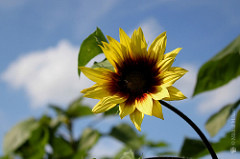

In [6]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [7]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and val 

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = ( img_height,img_width),
        batch_size = batch_size,)

    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        subset = "validation",
        validation_split=0.2,
        seed = 123,
        image_size = ( img_height, img_width),
        batch_size = batch_size,)

    return train_ds, test_ds


In [8]:
train_ds, test_ds = train_test_split(64,64,64)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [9]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


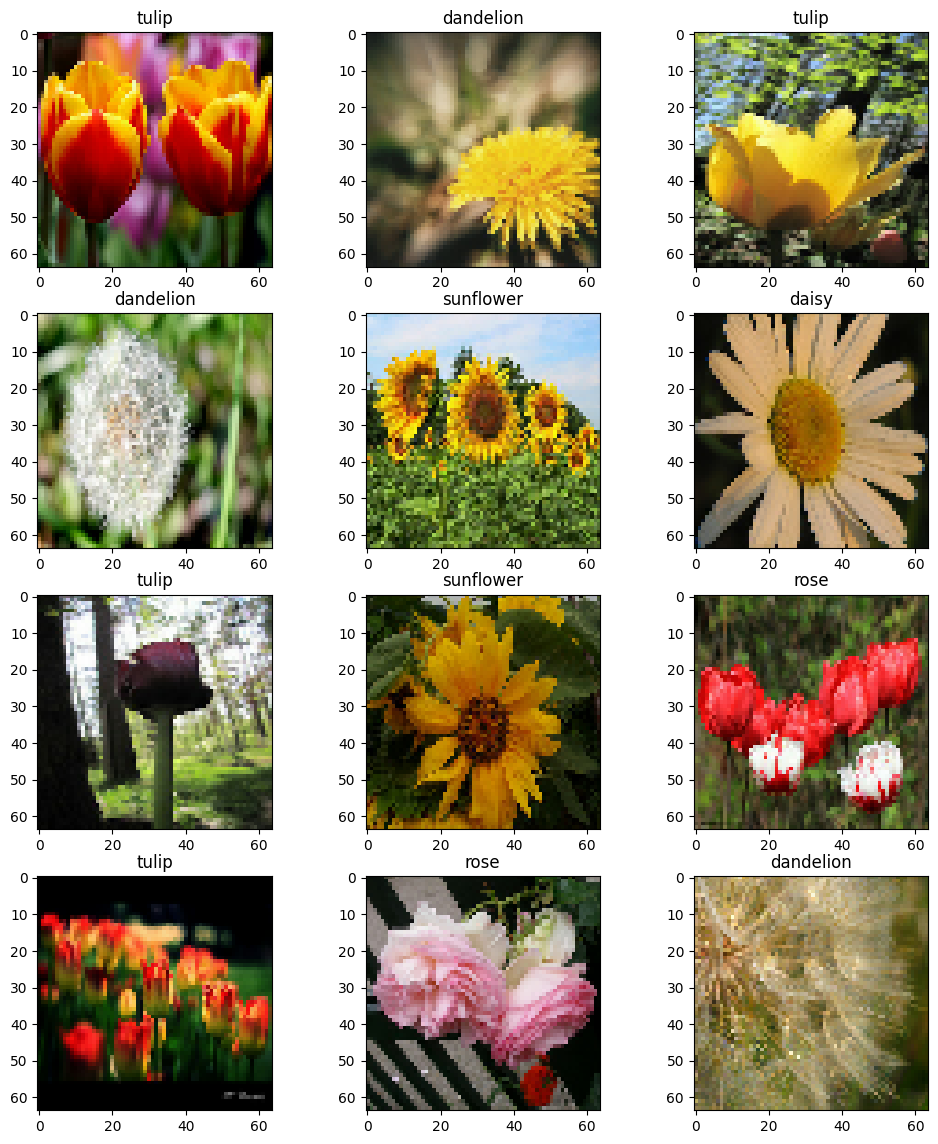

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        

        plt.title(class_names[labels[i]])
        

In [11]:
def keras_ds_to_numpy_array(train_ds, test_ds):
    
    train_images = []
    train_labels = []
    for batch in train_ds.as_numpy_iterator():
        train_images.append(batch[0])
        train_labels.append(batch[1])

    test_images = []
    test_labels = []
    for batch in test_ds.as_numpy_iterator():
        test_images.append(batch[0])
        test_labels.append(batch[1])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    print(f"Train Images shape:", {train_images.shape})
    print(f"Train Labels Shape:" ,{train_labels.shape})
    print(f"Number of Train Samples:", {len(train_images)})
    print(f"Number of Train labels:" ,{len(train_labels)})

    print(f"Test Images shape:", {test_images.shape})
    print(f"Test Labels Shape:" ,{test_labels.shape})
    print(f"Number of Test Samples:", {len(test_images)})
    print(f"Number of Test labels:", {len(test_labels)})

    return train_images, train_labels, test_images, test_labels

In [12]:
# testing the function with batchsize 32, height 180 and 180
train_images, train_labels, test_images, test_labels =  keras_ds_to_numpy_array(train_ds, test_ds)

Train Images shape: {(3454, 64, 64, 3)}
Train Labels Shape: {(3454,)}
Number of Train Samples: {3454}
Number of Train labels: {3454}
Test Images shape: {(863, 64, 64, 3)}
Test Labels Shape: {(863,)}
Number of Test Samples: {863}
Number of Test labels: {863}


## Building the model

I am going to use keras tuner to help find the best hyper parameters for my model. First i have to build a function that will have the different parameters that i will try to build the best model 

In [16]:
img_height = 64
img_width = 64

def model_builder(hp):
    
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

    # input layer 
    model.add(layers.Conv2D(
        filters=hp.Int("input_filters", min_value=32, max_value=256, step=32),
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    for i in range(hp.Int("n_conv_layers", 1,4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f"conv_{i}_filters", min_value=32, max_value=256, step=32),
            kernel_size=3,
            activation="relu",
            padding="same")
        )
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    for i in range(hp.Int("n_dense_layers", 1,4)):
        model.add(layers.Dense(
            units=hp.Choice(f"n_nodes_{i}", values= [10, 20, 50, 100]), #changed these to small values
            activation="relu")
        )
        
    model.add(layers.Dense(5)) # maybe make it more scalable
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

## Now I have created my model it is time to do run the keras tuner to find the best hyper parameters for my model

In [17]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner_results',
                     project_name='flowers')

Reloading Tuner from tuner_results/flowers/tuner0.json


In [18]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [19]:
tuner.search(train_images, train_labels, epochs=50,validation_split=0.2, callbacks=[early_stopping])  #validation_split=0.2,


In [20]:
best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 160)       9

### now i will train my model with best parameters

In [32]:
def train_and_evaluate_model(best_hyperparameters, epochs):

    checkpoint_filepath = "../best_model/checkpoint.model.keras"
    
    model = tuner.hypermodel.build(best_hyperparameters)

    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",mode="min", verbose=1, patience=3)
    #h5py.ModelCheckpoint("best_model.h5", monitor="val_loss", mode="min", save_best_only= True, verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True)
    


    history = model.fit(train_images,train_labels , epochs=epochs, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

    test_loss, test_accuracy =model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    plt.figure(figsize=(8,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return keras.models.load_model(checkpoint_filepath)
    

    



Epoch 1/25
87/87 [==============================] - ETA: 0s - loss: 1.4727 - accuracy: 0.3246
Epoch 1: val_accuracy improved from -inf to 0.43126, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 39s 428ms/step - loss: 1.4727 - accuracy: 0.3246 - val_loss: 1.3295 - val_accuracy: 0.4313
Epoch 2/25
87/87 [==============================] - ETA: 0s - loss: 1.2588 - accuracy: 0.4426
Epoch 2: val_accuracy improved from 0.43126 to 0.45586, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 40s 460ms/step - loss: 1.2588 - accuracy: 0.4426 - val_loss: 1.2085 - val_accuracy: 0.4559
Epoch 3/25
87/87 [==============================] - ETA: 0s - loss: 1.1177 - accuracy: 0.5338
Epoch 3: val_accuracy improved from 0.45586 to 0.56874, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 37s 429ms/step - loss: 1.1177 - accuracy: 0.5338 - val_loss: 1.0426 - val_accuracy: 0.568

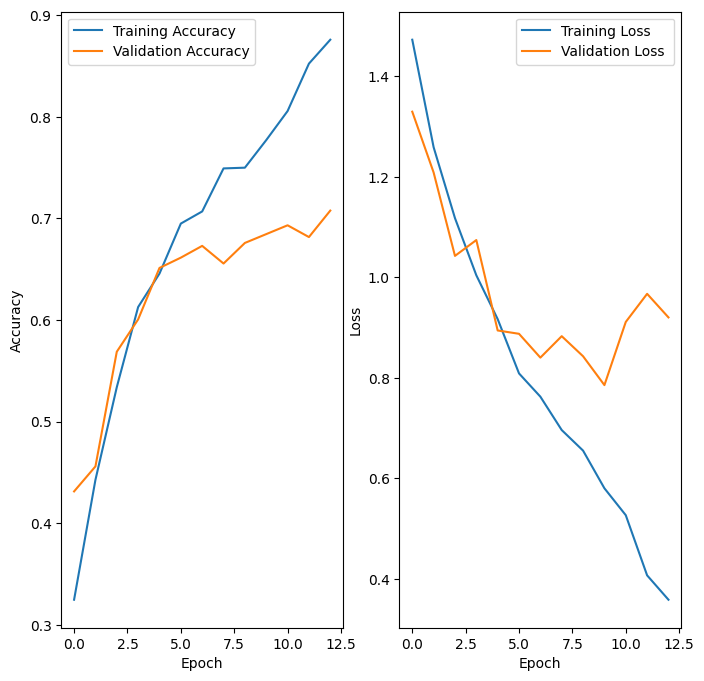

In [200]:
train_and_evaluate_model(best_hyperparameters, 25)

It is noticeable that there is some over fitting within the model. The training accuracy is consistent in the way it continues to improve while the Validation drops out around 70 % accuracy. This can occur if the dta set is too small. I would like to try and improve this. I will try first to use Data augmentation. This adds additional training data by creating random differences od the original images. This is done by example zooming in and rotating. This will hopefully expose the model to more data and generalizations.

I will now add this into my model function and see if it has any improvements. Then I will take the best model again and train that to see if the results are better.

Now I will test the new model 

In [44]:
def train_and_evaluate_model(epochs, img_width, img_height):
    
    model= keras.Sequential([
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),

        layers.Conv2D(128, (3,3), activation ="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation ="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(160, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(224, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(224, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        layers.Dense(50, activation="relu"),

        layers.Dropout(0.5),

        layers.Dense(5),

        layers.Activation("softmax")


    ])


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate= 0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    checkpoint_filepath = "../best_model/checkpoint.model.keras"

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True
    )

    history = model.fit(train_images, train_labels, epochs=epochs, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return keras.models.load_model(checkpoint_filepath)


Epoch 1/25
87/87 [==============================] - ETA: 0s - loss: 1.5569 - accuracy: 0.2845
Epoch 1: val_accuracy improved from -inf to 0.41823, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 47s 518ms/step - loss: 1.5569 - accuracy: 0.2845 - val_loss: 1.3727 - val_accuracy: 0.4182
Epoch 2/25
87/87 [==============================] - ETA: 0s - loss: 1.3621 - accuracy: 0.4007
Epoch 2: val_accuracy improved from 0.41823 to 0.47467, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 47s 540ms/step - loss: 1.3621 - accuracy: 0.4007 - val_loss: 1.3191 - val_accuracy: 0.4747
Epoch 3/25
87/87 [==============================] - ETA: 0s - loss: 1.2573 - accuracy: 0.4444
Epoch 3: val_accuracy improved from 0.47467 to 0.49638, saving model to ../best_model/checkpoint.model.keras
87/87 [==============================] - 42s 485ms/step - loss: 1.2573 - accuracy: 0.4444 - val_loss: 1.2146 - val_accuracy: 0.496

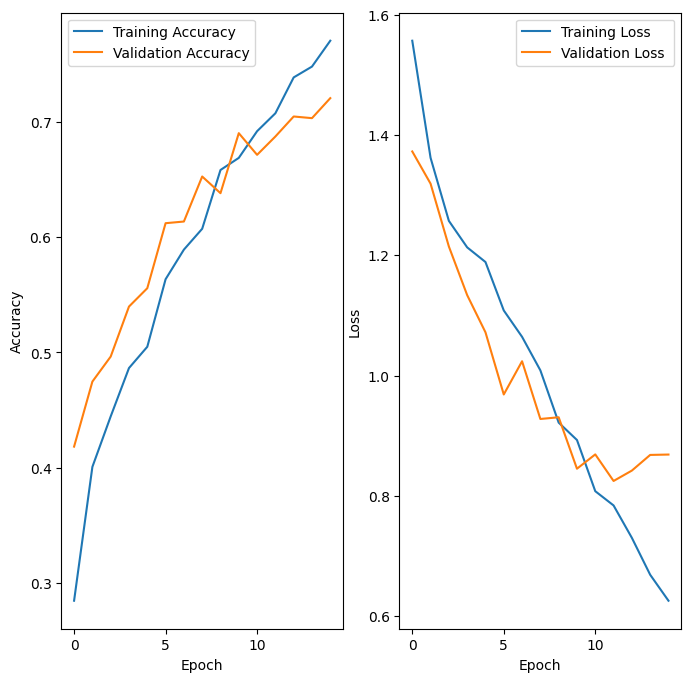

In [45]:
train_and_evaluate_model(25, 64,64)